In [1]:
is_colab = 'google.colab' in str(get_ipython())

In [2]:
if is_colab:
    %pip install neuron
    %pip install neuron_reduce
    %git clone https://github.com/davidfague/Neural-Modeling.git

In [3]:
if is_colab:
    %cd Neural-Modeling/

from Modules.synapse_generator import SynapseGenerator
from Modules.reduction import Reductor
from Modules.cell_model import CellModel
from Modules.spike_generator import SpikeGenerator
from Modules.complex_cell import build_L5_cell
from Modules.functional_group import FunctionalGroup, Cluster, generate_functional_groups
from Modules.cell_utils import get_segments_and_len_per_segment

import numpy as np
from functools import partial
import scipy.stats as st

from neuron import h

In [4]:
# Global vars
reduce_cell = False
expand_cable = False
choose_branches = 22

complex_cell_folder = 'complex_cells/L5PC/'

# Simulation params
h_celcius = 37 # Sim runtime
h_tstop = 500
h_dt = 0.1 # Timestep (ms)

# Time vector for generating inputs
t = np.arange(0, h_tstop, 1)

## Build Complex Cell

### Compile modfiles

In [5]:
%%capture

# If this cell doesn't work, delete the compiled modfiles and restart the kernel
!nrnivmodl modfiles
h.load_file('stdrun.hoc')
h.nrn_load_dll('./x86_64/.libs/libnrnmech.so') # load modfiles

### Build cell

In [6]:
complex_cell = build_L5_cell(complex_cell_folder)

h.celsius = h_celcius
h.v_init = complex_cell.soma[0].e_pas

# Sim runtime
h.tstop = h_tstop

# Timestep (ms)
h.dt = h_dt
h.steps_per_ms = 1 / h.dt

In [7]:
Reductor(cell = complex_cell, method = 'lambda')

Model nseg changed from 642 to 196


### Create Functional Groups and Synaptic Clusters

In [8]:
all_segments, all_len_per_segment = get_segments_and_len_per_segment(complex_cell)

#### Excitatory

In [9]:
# Excitatory gmax distribution
exc_gmax_mean_0 = 0.2
exc_gmax_std_0 = 0.345

gmax_mean = np.log(exc_gmax_mean_0) - 0.5 * np.log((exc_gmax_std_0 / exc_gmax_mean_0) ** 2 + 1)
gmax_std = np.sqrt(np.log((exc_gmax_std_0 / exc_gmax_mean_0) ** 2 + 1))

# gmax distribution
gmax_exc_dist = partial(np.random.lognormal, gmax_mean, gmax_std, size = 1)

# Excitatory firing rate distribution
def exp_levy_dist(alpha = 1.37, beta = -1.00, loc = 0.92, scale = 0.44, size = 1):
	return np.exp(st.levy_stable.rvs(alpha = alpha, beta = beta, loc = loc, scale = scale, size = size)) + 1e-15

In [10]:
spike_generator = SpikeGenerator()
synapse_generator = SynapseGenerator()

In [11]:
synaptic_density = 2.12
functional_group_span = 100
cluster_span = 10
synapses_per_cluster = 5

number_of_groups = int(sum(all_len_per_segment) / functional_group_span)

# Number of presynaptic cells
cells_per_group = int(functional_group_span*synaptic_density / synapses_per_cluster)

# Distribution of mean firing rates
mean_fr_dist = partial(exp_levy_dist, alpha = 1.37, beta = -1.00, loc = 0.92, scale = 0.44, size = 1) 

In [12]:
functional_groups = generate_functional_groups(cell = complex_cell,
                                               all_segments = all_segments,
                                               all_len_per_segment = all_len_per_segment, 
                                               number_of_groups = number_of_groups,
                                               cells_per_group = cells_per_group,
                                               synapses_per_cluster = synapses_per_cluster,
                                               functional_group_span = functional_group_span,
                                               cluster_span = cluster_span,
                                               gmax_dist = gmax_exc_dist,
                                               mean_fr_dist = mean_fr_dist,
                                               spike_generator = spike_generator,
                                               synapse_generator = synapse_generator,
                                               t = t)

In [13]:
exc_spikes = spike_generator.spike_trains

#### Inhibitory

In [14]:
rnd = np.random.RandomState(10)

In [15]:
synaptic_density = 0.22
cluster_span = 10

synapses = synaptic_density * sum(all_len_per_segment)
number_of_clusters = int(sum(all_len_per_segment) / cluster_span)
synapses_per_cluster = int(cluster_span*synaptic_density) # 12 # synapses/number_of_clusters
# synapses_per_node=5
# number_of_clusters=int(synapses / (cluster_span * synaptic_density)) # number of presynaptic cells

# Proximal inh mean_fr distribution
mean_fr, std_fr = 16.9, 14.3
a, b = (0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr
proximal_inh_dist = partial(st.truncnorm.rvs, a = a, b = b, loc = mean_fr, scale = std_fr)

# Distal inh mean_fr distribution
mean_fr, std_fr = 3.9, 4.3
a, b = (0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr
distal_inh_dist = partial(st.truncnorm.rvs, a=a, b=b, loc=mean_fr, scale=std_fr)

gmax_dist = 1 # need inh gmax distribution
number_of_groups = 1

for GROUP in range(1): # create functional group
  center_seg=None
  func_grp=FunctionalGroup(complex_cell, center_seg, functional_group_span, name='diffuse inh') # generate functional group
  functional_groups.append(func_grp)
  #generate trace common to all cells within each functional group
  fr_profile=spike_generator.get_firing_rate_profile(t=t, method='delay', spike_trains_to_delay=exc_spikes, fr_time_shift=4)
  for CELL in range(number_of_clusters):# iterate through cells which each have a cluster of synapses
    cluster_seg=rnd.choice(all_segments, p=all_len_per_segment/sum(all_len_per_segment))
    cluster=Cluster(complex_cell, cluster_seg, cluster_span) # generate cluster
    if h.distance(cluster.center_seg, complex_cell.soma[0](0.5))<=50:
      mean_fr_dist = proximal_inh_dist
    else:
      mean_fr_dist = distal_inh_dist
    # add synapses to to the cluster
    cluster.synapses=synapse_generator.add_synapses(segments=cluster.segments,probs=cluster.len_per_segment,gmax=gmax_dist,syn_mod='GABA_AB',number_of_synapses=synapses_per_cluster)
    func_grp.synapses.append(cluster.synapses)
    func_grp.clusters.append(cluster)
    # generate spikes common to each synapse within synaptic cluster
    mean_fr=spike_generator.get_mean_fr(mean_fr_dist)
    spikes = spike_generator.generate_spikes_from_profile(fr_profile,mean_fr)
    for synapse in cluster.synapses:
      # print(synapse, synapse.synapse_neuron_obj)
      cluster.netcons_list.append(spike_generator.set_spike_train(synapse, spikes))
      cluster.spike_trains.append(spikes)


In [17]:
# 150 soma inh synapses

soma_segments=[]
soma_len_per_segment=[]
for sec in complex_cell.soma:
  for seg in sec:
    soma_segments.append(seg)
    soma_len_per_segment.append(seg.sec.nseg/seg.sec.L)
soma_len_per_segment=np.array(soma_len_per_segment)

num_clusters=15 # number of presynaptic cells
cluster_span=10
synapses_per_cluster=10

for GROUP in range(1): # create functional group
  center_seg=None
  func_grp=FunctionalGroup(complex_cell, center_seg, functional_group_span, name = 'soma inh') # generate functional group
  functional_groups.append(func_grp)
  #generate trace common to all cells within each functional group
  fr_profile=spike_generator.get_firing_rate_profile(t=t, method='delay', spike_trains_to_delay=exc_spikes, fr_time_shift=4)
  for CELL in range(num_clusters):# iterate through cells which each have a cluster of synapses
    cluster_seg=rnd.choice(soma_segments, p=soma_len_per_segment/sum(soma_len_per_segment))
    cluster=Cluster(complex_cell, cluster_seg, cluster_span) # generate cluster
    if h.distance(cluster.center_seg, complex_cell.soma[0](0.5))<=50:
      gmax_dist = proximal_inh_dist
    else:
      gmax_dist = distal_inh_dist
    # add synapses to to the cluster
    cluster.synapses=synapse_generator.add_synapses(segments=cluster.segments, probs=cluster.len_per_segment, gmax=gmax_dist ,syn_mod='GABA_AB', number_of_synapses=synapses_per_cluster)
    func_grp.synapses.append(cluster.synapses)
    func_grp.clusters.append(cluster)
    # generate spikes common to each synapse within synaptic cluster
    mean_fr=spike_generator.get_mean_fr(mean_fr_dist)
    spikes = spike_generator.generate_spikes_from_profile(fr_profile,mean_fr)
    for synapse in cluster.synapses:
      cluster.netcons_list.append(spike_generator.set_spike_train(synapse, spikes))
      cluster.spike_trains.append(spikes)


In [18]:
all_syns=[]
for synapse_list in synapse_generator.synapses: # synapse_generator.synapses is a list of synapse lists
  for synapse in synapse_list:
    all_syns.append(synapse.synapse_neuron_obj)

In [19]:
cell = CellModel(hoc_model=complex_cell, synapses=all_syns, netcons=spike_generator.netcons, spike_threshold=10)

Generating 3D coordinates for L5PCtemplate[0].axon[0]
Generating 3D coordinates for L5PCtemplate[0].axon[1]


/Users/vladimiromelyusik/Neural-Modeling/Modules/cell_model.py:74: RuntimeWarning: Generation of 3D coordinates resulted in change of section length for L5PCtemplate[0].axon[1] from 30.0 to 29.999996185302734
  warnings.warn(f"Generation of 3D coordinates resulted in change of section length for {sec} from {old_length} to {sec.L}",


In [20]:
# Reduce cell and store new things: can update CellModel module to do this stuff

def find_distal_sections(cell, region=str):
  '''
  Finds all terminal sections then gathers terminal apical sections that are greater than 800 microns from the soma in path length
  '''
  # find distal tuft sections:
  parent_sections=[]
  for sec in cell.all: # find non-terminal sections
    if sec.parentseg() is not None:
      if sec.parentseg().sec not in parent_sections:
        parent_sections.append(sec.parentseg().sec)
  terminal_sections=[]
  for sec in getattr(cell,region):  # check if the section is a terminal section and if it is apical tuft
    # print(h.distance(sec(0.5)))
    if region=='apic':
      if (sec not in parent_sections) and (h.distance(cell.soma[0](0.5),sec(0.5)) > 800):
        terminal_sections.append(sec)
    else:
      if (sec not in parent_sections):
        terminal_sections.append(sec)

      # print(sec, 'is a terminal section of the tuft'

  return terminal_sections

#reduce cell
if reduce_cell==True:
  #reduce complex dendritic trees to cables
  reduced_cell, synapses_list, netcons_list, txt_nr = subtree_reductor(complex_cell, synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True)
  print("synapses_list after NR reduction:", synapses_list)
  if expand_cable==True:
    #expand cable to idealized dendritic trees
    sections_to_expand = [reduced_cell.hoc_model.apic[0]]
    furcations_x=[0.289004]
    nbranches=[choose_branches]
    reduced_dendritic_cell, synapses_list, netcons_list, txt_ce = cable_expander(reduced_cell, sections_to_expand, furcations_x, nbranches,
                                                                              synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True)
    #remove basal dend 3d coordinates because they seem off
    for sec in reduced_dendritic_cell.dend:
      sec.pt3dclear()

    cell = CellModel(reduced_dendritic_cell,synapses_list=synapses_list,netcons_list=netcons_list,spike_threshold = 10) #NR model with apical cable converted to tree
    tufts=find_distal_sections(cell, 'apic')
    basals=find_distal_sections(cell, 'dend')
    cell._nbranch=len(tufts)

    print(cell._nbranch, "terminal tuft branches in reduced_dendritic_cell")
  else:
    #workaround since cell.all was not attribute (can update cell_model class to include this list formation)
    reduced_cell.all =[]
    for sec in [reduced_cell.soma]:
      reduced_cell.all.append(sec)
    for sec in [reduced_cell.apic]:
      reduced_cell.all.append(sec)
    for sec in reduced_cell.dend:
      reduced_cell.all.append(sec)
    for sec in reduced_cell.axon:
      reduced_cell.all.append(sec)
    #make apic sec a list (can update cell_model class to include this) (cell_model class expects cell.apic to be iterable)
    reduced_cell.apic=[reduced_cell.apic]
    #use cell_model python class
    cell=CellModel(reduced_cell,synapses_list=synapses_list,netcons_list=netcons_list,spike_threshold = 10) # neuron_reduce model
    tufts=cell.apic # Vm plot may return middle segment of trunk since it is the distal apical section.
    basals=find_distal_sections(cell, 'dend')
    cell._nbranch=len(tufts)
    print(cell._nbranch, "terminal tuft branches in reduced_cell")
else:
  basals=find_distal_sections(cell, 'dend')
  tufts=find_distal_sections(cell, 'apic')
  # cell = cell_model(complex_cell,synapses_list=synapses_list,netcons_list=netcons_list,spike_threshold = 10) # original cell
  # original cell should already be defined
  pass

In [22]:
import os

RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !pip install neuron==8.0.0 &> /dev/null
    os.chdir('/content')
    if not os.path.isdir('Stylized-Single-Cell-and-Extracellular-Potential'):
        !git clone https://github.com/chenziao/Stylized-Single-Cell-and-Extracellular-Potential.git &> /dev/null
    os.chdir('Stylized-Single-Cell-and-Extracellular-Potential')
    %ls

cell_inference/  Stylized_Single_Cell_Extracellular_Potential_Tutorial.ipynb


### Prepare Simulation

In [21]:
from cell_inference.config import params, paths
from cell_inference.cells.activecell_axon import ReducedOrderL5Cell, ReducedOrderL5CellPassiveDendrite
from cell_inference.utils.currents.ecp import EcpMod
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.utils.plotting.plot_morphology import plot_morphology
from cell_inference.utils.plotting.plot_results import plot_lfp_heatmap, plot_lfp_traces
from cell_inference.utils.plotting.plot_variable_with_morphology import plot_variable_with_morphology
from cell_inference.utils.metrics.measure_segment_distance import measure_segment_distance

In [22]:
# Record time points
t_vec = h.Vector(round(h.tstop / h.dt) + 1).record(h._ref_t)

# Record membrane voltage of all segments
V_rec = Recorder(cell.segments)

### Add electrodes (Neuropixel)
A probe with 384 electrodes [https://www.neuropixels.org/probe](https://www.neuropixels.org/probe). The coordinates of each electrode is a row in the array printed below.

In [23]:
elec_pos = params.ELECTRODE_POSITION
ecp = EcpMod(cell, elec_pos, min_distance=params.MIN_DISTANCE)  # create an ECP object for extracellular potential

# coordinates (x, y, z) of electrodes
# print(params.ELECTRODE_POSITION.shape)
# print(params.ELECTRODE_POSITION)

## Custom settings

Using the interactive tools below, you can change the position of the cell, and change the synapse strength and location on the cell.

#### Cell position parameters (x, y, z, alpha, h, phi)
Starting with soma at the origin, apical dendrite along y-axis, rotate and translate the cell to the desired position determined by 6 parameters. First, rotate alpha about the y-axis (spin), then rotate beta=arccos(h) about the x-axis (elevation), then rotate phi about the y-axis (azimuth). Finally translate the cell by (x,y,z).

Use the sliders to change the 6 position parameters. Use the sliders 'elev' and 'azim' to change view of the 3D plot.

In [24]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import numpy as np
from typing import Union, Optional, List, Tuple

import ipywidgets as widgets
from ipywidgets import interactive_output, HBox, VBox, Label, Layout

from cell_inference.utils.currents.ecp import move_position
from cell_inference.cells.stylizedcell import StylizedCell


def plot_morphology(sim: Optional = None, cellid: Optional[int] = 0, cell: Optional[StylizedCell] = None,
                    seg_coords: Optional[dict] = None, sec_nseg: Optional[List] = None,
                    type_id: Optional[List] = None, electrodes: Optional[np.ndarray] = None,
                    axes: Union[List[int], Tuple[int]] = [2, 0, 1], clr: Optional[List[str]] = None,
                    elev: int = 20, azim: int = 10, move_cell: Optional[Union[List,np.ndarray]] = None,
                    figsize: Optional[Tuple[float, float]] = None) -> Tuple[Figure, Axes]:
    """
    Plot morphology in 3D.

    sim: simulation object
    cellid: cell id in the simulation object. Default: 0
    cell: stylized cell object. Ignore sim and cellid if specified
    seg_coords: if not using sim or cell, a dictionary that includes dl, pc, r
    sec_nseg: if not using sim or cell, list of number of segments in each section
    type_id:  if not using sim or cell, list of the swc type id of each section/segment
    electrodes: electrode positions. Default: None, not shown.
    axes: sequence of axes to display in 3d plot axes.
        Default: [2,0,1] show z,x,y in 3d plot x,y,z axes, so y is upward.
    clr: list of colors for each type of section
    Return Figure object, Axes object
    """
    if sim is None and cell is None:
        if seg_coords is None or sec_nseg is None or type_id is None:
            raise ValueError("If not using 'Simulation', input arguments 'seg_coords', 'sec_nseg', 'type_id' are required.")
        if clr is None:
            clr = ('g', 'r', 'b', 'c')
        if move_cell is None:
            move_cell = [0., 0., 0., 0., 1., 0.]
        sec_id_in_seg = np.cumsum([0] + list(sec_nseg[:-1]))
        type_id = np.asarray(type_id) - 1
        if type_id.size != len(sec_nseg):
            type_id = type_id = type_id[sec_id_in_seg]
        type_id = type_id.tolist()
        label_idx = np.array([type_id.index(i) for i in range(4)])
        lb_odr = np.argsort(label_idx)
        label_idx = label_idx[lb_odr].tolist()
        sec_name = np.array(('soma','axon','dend','apic'))[lb_odr]
    else:
        if clr is None:
            clr = ('g', 'b', 'pink', 'purple', 'r', 'c')
        if cell is None:
            if move_cell is None:
                move_cell = sim.loc_param[cellid, 0]
            cell = sim.cells[cellid]
        elif move_cell is None:
            move_cell = [0., 0., 0., 0., 1., 0.]
        seg_coords = cell.seg_coords
        sec_id_in_seg = cell.sec_id_in_seg
        sec_nseg = []
        sec_name = []
        label_idx = []
        type_id = []
        for i, sec in enumerate(cell.all):
            sec_nseg.append(sec.nseg)
            name = sec.name().split('.')[-1]
            if name not in sec_name:
                sec_name.append(name)
                label_idx.append(i)
            type_id.append(sec_name.index(name))
    label_idx.append(-1)

    move_cell = np.asarray(move_cell).reshape((2, 3))
    dl = move_position([0., 0., 0.], move_cell[1], seg_coords['dl'])
    pc = move_position(move_cell[0], move_cell[1], seg_coords['pc'])
    xyz = 'xyz'
    box = np.vstack([np.full(3, np.inf), np.full(3, np.NINF)])
    if electrodes is not None:
        box[0, axes[0:2]] = np.amin(electrodes[:, axes[0:2]], axis=0)
        box[1, axes[0:2]] = np.amax(electrodes[:, axes[0:2]], axis=0)

    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    lb_ptr = 0
    for i, itype in enumerate(type_id):
        label = sec_name[lb_ptr] if i == label_idx[lb_ptr] else None
        if label is not None: lb_ptr += 1
        i0 = sec_id_in_seg[i]
        i1 = i0 + sec_nseg[i] - 1
        if sec_name[itype] == 'soma':
            p05 = (pc[i0] + pc[i1]) / 2
            ax.scatter(*[p05[j] for j in axes], c=clr[itype], s=20, label=label)
        else:
            p0 = pc[i0] - dl[i0] / 2
            p1 = pc[i1] + dl[i1] / 2
            ax.plot3D(*[(p0[j], p1[j]) for j in axes], color=clr[itype], label=label)
            box[0, :] = np.minimum(box[0, :], np.minimum(p0, p1))
            box[1, :] = np.maximum(box[1, :], np.maximum(p0, p1))
    ctr = np.mean(box, axis=0)
    r = np.amax(box[1, :] - box[0, :]) / 2
    box = np.vstack([ctr - r, ctr + r])
    if electrodes is not None:
        idx = np.logical_and(np.all(electrodes >= box[0, :], axis=1), np.all(electrodes <= box[1, :], axis=1))
        ax.scatter(*[(electrodes[idx, j], electrodes[idx, j]) for j in axes], color='orange', s=5, label='electrodes')
    box = box[:, axes]
    ax.auto_scale_xyz(*box.T)
    ax.view_init(elev, azim)
    # ax.legend(loc=1)
    ax.set_xlabel(xyz[axes[0]])
    ax.set_ylabel(xyz[axes[1]])
    ax.set_zlabel(xyz[axes[2]])
    plt.show()
    return fig, ax

In [25]:
loc_param_default = [0., 0., 80., 0., 1., 0.]  # Default position parameters
elev, azim = 10, 90  # Default view
# clr = ['g', 'yellow', 'orange', 'red', 'b', 'c', 'g', 'yellow', 'orange', 'red', 'pink', 'purple']  # section color
clr=[]
clr.extend(['black' for i in range(len([cell.soma]))]) # soma color
clr.extend(['red' for i in range(len(cell.dend))]) #dend colors
clr.extend(['purple' for i  in range(len(cell.axon))]) # axon colors
clr.extend(['blue']) #trunk color
clr.extend(['green' for i in range(len(cell.apic)-1)])  # branch colors

def interactive_plot(x, y, z, alpha, beta, phi, elev, azim):
    global loc_param
    loc_param = (x, y, z, np.pi/180*alpha, np.cos(np.pi/180*beta), np.pi/180*phi)
    fig, ax = plot_morphology(cell=cell, electrodes=elec_pos, move_cell=loc_param,
                    elev=-elev, azim=-azim, figsize=(12, 8), clr = clr)
    plt.show()

xslider = Layout(width='500px')
yslider = Layout(height='350px')
w_reset = widgets.Button(description='Reset', icon='history', button_style='primary')
w_x = widgets.FloatSlider(value=loc_param_default[0], min=-200, max=200, step=1, description='x (um)', continuous_update=False, readout_format='.0f')
w_y = widgets.FloatSlider(value=loc_param_default[1], min=-1000, max=1000, step=1, description='y (um)', continuous_update=False, readout_format='.0f')
w_z = widgets.FloatSlider(value=loc_param_default[2], min=20, max=400, step=1, description='z (um)', continuous_update=False, readout_format='.0f')
w_alpha = widgets.FloatSlider(value=180/np.pi*loc_param_default[3], min=-180, max=180, step=1, description='alpha (deg)', continuous_update=False, readout_format='.0f')
w_beta = widgets.FloatSlider(value=180/np.pi*np.arccos(loc_param_default[4]), min=0, max=180, step=1, description='beta (deg)', continuous_update=False, readout_format='.0f')
w_phi = widgets.FloatSlider(value=180/np.pi*loc_param_default[5], min=-180, max=180, step=1, description='phi (deg)', continuous_update=False, readout_format='.0f')
w_elev = widgets.FloatSlider(value=-elev, min=-90, max=90, step=1, description='elev (deg)', continuous_update=False, readout_format='.0f', orientation='vertical', layout=yslider)
w_azim = widgets.FloatSlider(value=-azim, min=-180, max=180, step=1, description='azim (deg)', continuous_update=False, readout_format='.0f', layout=xslider)

def reset_default(*args):
    w_x.value, w_y.value, w_z.value = loc_param_default[:3]
    w_alpha.value = 180 / np.pi * loc_param_default[3]
    w_beta.value = 180 / np.pi * np.arccos(loc_param_default[4])
    w_phi.value = 180 / np.pi * loc_param_default[5]
    w_elev.value, w_azim.value = -elev, -azim
w_reset.on_click(reset_default)

out = interactive_output(interactive_plot, {'x': w_x, 'y': w_y, 'z': w_z, 'alpha': w_alpha, 'beta': w_beta, 'phi': w_phi, 'elev': w_elev, 'azim': w_azim})
ui = VBox([ w_reset, HBox([ VBox([w_x, w_y, w_z]), VBox([w_alpha, w_beta, w_phi]) ]), HBox([ VBox([out, w_azim]), w_elev]) ])

display(ui)

set azim to -90 in order to focus on zy plane view. 2D plot is of xy plane.

In [26]:
#TESTING UPDATES to have color be representative of segment property
def plot_morphology(seg_property: Optional = None,segment_colors: Optional = None,sim: Optional = None, cellid: Optional[int] = 0, cell: Optional[StylizedCell] = None,
                    seg_coords: Optional[dict] = None, sec_nseg: Optional[List] = None,
                    type_id: Optional[List] = None, electrodes: Optional[np.ndarray] = None,
                    axes: Union[List[int], Tuple[int]] = [2, 0, 1], clr: Optional[List[str]] = None,
                    elev: int = 20, azim: int = 10, move_cell: Optional[Union[List,np.ndarray]] = None,
                    figsize: Optional[Tuple[float, float]] = None) -> Tuple[Figure, Axes]:
    """
    Plot morphology in 3D.

    sim: simulation object
    cellid: cell id in the simulation object. Default: 0
    cell: stylized cell object. Ignore sim and cellid if specified
    seg_coords: if not using sim or cell, a dictionary that includes dl, pc, r
    sec_nseg: if not using sim or cell, list of number of segments in each section
    type_id:  if not using sim or cell, list of the swc type id of each section/segment
    electrodes: electrode positions. Default: None, not shown.
    axes: sequence of axes to display in 3d plot axes.
        Default: [2,0,1] show z,x,y in 3d plot x,y,z axes, so y is upward.
    clr: list of colors for each type of section
    Return Figure object, Axes object
    """
    if sim is None and cell is None:
        if seg_coords is None or sec_nseg is None or type_id is None:
            raise ValueError("If not using 'Simulation', input arguments 'seg_coords', 'sec_nseg', 'type_id' are required.")
        if clr is None:
            clr = ('g', 'r', 'b', 'c')
        if move_cell is None:
            move_cell = [0., 0., 0., 0., 1., 0.]
        sec_id_in_seg = np.cumsum([0] + list(sec_nseg[:-1]))
        type_id = np.asarray(type_id) - 1
        if type_id.size != len(sec_nseg):
            type_id = type_id = type_id[sec_id_in_seg]
        type_id = type_id.tolist()
        label_idx = np.array([type_id.index(i) for i in range(4)])
        lb_odr = np.argsort(label_idx)
        label_idx = label_idx[lb_odr].tolist()
        sec_name = np.array(('soma','axon','dend','apic'))[lb_odr]
    else:
        if clr is None:
            clr = ('g', 'b', 'pink', 'purple', 'r', 'c')
        if cell is None:
            if move_cell is None:
                move_cell = sim.loc_param[cellid, 0]
            cell = sim.cells[cellid]
        elif move_cell is None:
            move_cell = [0., 0., 0., 0., 1., 0.]
        seg_coords = cell.seg_coords
        sec_id_in_seg = cell.sec_id_in_seg
        sec_nseg = []
        sec_name = []
        label_idx = []
        type_id = []
        for i, sec in enumerate(cell.all):
            sec_nseg.append(sec.nseg)
            name = sec.name().split('.')[-1]
            if name not in sec_name:
                sec_name.append(name)
                label_idx.append(i)
            type_id.append(sec_name.index(name))
    label_idx.append(-1)

    move_cell = np.asarray(move_cell).reshape((2, 3))
    dl = move_position([0., 0., 0.], move_cell[1], seg_coords['dl'])
    pc = move_position(move_cell[0], move_cell[1], seg_coords['pc'])
    xyz = 'xyz'
    box = np.vstack([np.full(3, np.inf), np.full(3, np.NINF)])
    if electrodes is not None:
        box[0, axes[0:2]] = np.amin(electrodes[:, axes[0:2]], axis=0)
        box[1, axes[0:2]] = np.amax(electrodes[:, axes[0:2]], axis=0)

    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    lb_ptr = 0
    if segment_colors is None:
      for i, itype in enumerate(type_id):
          label = sec_name[lb_ptr] if i == label_idx[lb_ptr] else None
          if label is not None: lb_ptr += 1
          i0 = sec_id_in_seg[i] #segments list index of first segment of this section
          i1 = i0 + sec_nseg[i] - 1 #segments list index of last segment of this section
          if sec_name[itype] == 'soma':
              p05 = (pc[i0] + pc[i1]) / 2
              ax.scatter(*[p05[j] for j in axes], c=clr[itype], s=20, label=label)
          else:
              for seg_index in range(i0,i1+1):
                p0 = pc[seg_index] - dl[seg_index]/2
                p1 = pc[seg_index] + dl[seg_index]/2
                ax.plot3D(*[(p0[j], p1[j]) for j in axes], color=clr[itype], label=label)
                box[0, :] = np.minimum(box[0, :], np.minimum(p0, p1))
                box[1, :] = np.maximum(box[1, :], np.maximum(p0, p1))
    else:
      for i, itype in enumerate(type_id):
          label = sec_name[lb_ptr] if i == label_idx[lb_ptr] else None
          if label is not None: lb_ptr += 1
          i0 = sec_id_in_seg[i] #segments list index of first segment of this section
          i1 = i0 + sec_nseg[i] - 1 #segments list index of last segment of this section
          if sec_name[itype] == 'soma':
              p05 = (pc[i0] + pc[i1]) / 2
              ax.scatter(*[p05[j] for j in axes], c=clr[itype], s=20, label=label)
          else:
              for seg_index in range(i0,i1+1):
                p0 = pc[seg_index] - dl[seg_index]/2
                p1 = pc[seg_index] + dl[seg_index]/2
                ax.plot3D(*[(p0[j], p1[j]) for j in axes], color=segment_colors[seg_index], label=label)
                box[0, :] = np.minimum(box[0, :], np.minimum(p0, p1))
                box[1, :] = np.maximum(box[1, :], np.maximum(p0, p1))

    # Add a colorbar to the plot
    # Create a new axes for the colorbar
    cbar_ax = fig.add_axes([0.75, 0.2, 0.03, 0.6])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    if seg_property is not None:
      cbar.set_label(seg_property)
    ctr = np.mean(box, axis=0)
    r = np.amax(box[1, :] - box[0, :]) / 2
    box = np.vstack([ctr - r, ctr + r])
    if electrodes is not None:
        idx = np.logical_and(np.all(electrodes >= box[0, :], axis=1), np.all(electrodes <= box[1, :], axis=1))
        ax.scatter(*[(electrodes[idx, j], electrodes[idx, j]) for j in axes], color='orange', s=5, label='electrodes')
    box = box[:, axes]
    ax.auto_scale_xyz(*box.T)
    ax.view_init(elev, azim)
    # ax.legend(loc=1)
    ax.set_xlabel(xyz[axes[0]])
    ax.set_ylabel(xyz[axes[1]])
    ax.set_zlabel(xyz[axes[2]])
    plt.show()
    return fig, ax

loc_param_default = [0., 0., 80., 0., 1., 0.]  # Default position parameters
elev, azim = 10, 90  # Default view
# clr = ['g', 'yellow', 'orange', 'red', 'b', 'c', 'g', 'yellow', 'orange', 'red', 'pink', 'purple']  # section color
clr=[]
clr.extend(['black' for i in range(len([cell.soma]))]) # soma color
clr.extend(['red' for i in range(len(cell.dend))]) #dend colors
clr.extend(['purple' for i  in range(len(cell.axon))]) # axon colors
clr.extend(['blue']) #trunk color
clr.extend(['green' for i in range(len(cell.apic)-1)])  # branch colors

def get_nested_property(seg, properties):
    if properties:
        property = properties[0]
        remaining_properties = properties[1:]
        if property in seg:
            if isinstance(seg[property], dict):
                if remaining_properties:
                    return get_nested_property(seg[property], remaining_properties)
                else:
                    return seg[property]
            elif len(remaining_properties) == 0:
                return seg[property]
            else:
                raise ValueError("Property list contains too many items for the depth of the target")
        else:
            raise ValueError(f"Property '{property}' not found in segment. Please specify a proper path in seg_info.")
    else:
        raise ValueError("Empty property list")

#identify the property being used #check cell.seg_info[0] for dictionary of properties (some are nested)
property_list = ['netcons_per_seg','total']
# property_list = ['seg_elec_info','beta','passive_soma']
seg_prop = [get_nested_property(seg, property_list) for seg in cell.seg_info]

def combine_strings(strings: list) -> str:
    """Combine a list of strings into one string separated by underscores."""
    return '_'.join(strings)

label = combine_strings(property_list)

# seg_prop=[seg['Center Z Coord'] for seg in cell.seg_info]
# seg_prop=[seg['seg_elec_info']['delta']['active_soma'] for seg in cell.seg_info]
# seg_prop=[seg['netcons_per_seg']['exc'] for seg in cell.seg_info]
seg_prop=np.array(seg_prop)
#normalized_seg_prop = (seg_prop - min(seg_prop)) / (max(seg_prop) - min(seg_prop))
# Define your percentile thresholds
lower, upper = np.percentile(seg_prop, [1, 99]) # you can adjust these percentiles to your needs
# Define normalization function based on these percentiles
robust_norm = plt.Normalize(vmin=lower, vmax=upper)
# Apply robust normalization to segment property
normalized_seg_prop = robust_norm(seg_prop)
cmap = plt.get_cmap('jet')
segment_colors = cmap(normalized_seg_prop)
# Create a ScalarMappable object to represent the colormap
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(seg_prop), vmax=max(seg_prop)))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=robust_norm)


def interactive_plot(x, y, z, alpha, beta, phi, elev, azim):
    global loc_param
    loc_param = (x, y, z, np.pi/180*alpha, np.cos(np.pi/180*beta), np.pi/180*phi)
    fig, ax = plot_morphology(seg_property=label,segment_colors=segment_colors,cell=cell, electrodes=elec_pos, move_cell=loc_param,
                    elev=-elev, azim=-azim, figsize=(12, 8), clr = clr)
    plt.show()

xslider = Layout(width='500px')
yslider = Layout(height='350px')
w_reset = widgets.Button(description='Reset', icon='history', button_style='primary')
w_x = widgets.FloatSlider(value=loc_param_default[0], min=-200, max=200, step=1, description='x (um)', continuous_update=False, readout_format='.0f')
w_y = widgets.FloatSlider(value=loc_param_default[1], min=-1000, max=1000, step=1, description='y (um)', continuous_update=False, readout_format='.0f')
w_z = widgets.FloatSlider(value=loc_param_default[2], min=20, max=400, step=1, description='z (um)', continuous_update=False, readout_format='.0f')
w_alpha = widgets.FloatSlider(value=180/np.pi*loc_param_default[3], min=-180, max=180, step=1, description='alpha (deg)', continuous_update=False, readout_format='.0f')
w_beta = widgets.FloatSlider(value=180/np.pi*np.arccos(loc_param_default[4]), min=0, max=180, step=1, description='beta (deg)', continuous_update=False, readout_format='.0f')
w_phi = widgets.FloatSlider(value=180/np.pi*loc_param_default[5], min=-180, max=180, step=1, description='phi (deg)', continuous_update=False, readout_format='.0f')
w_elev = widgets.FloatSlider(value=-elev, min=-90, max=90, step=1, description='elev (deg)', continuous_update=False, readout_format='.0f', orientation='vertical', layout=yslider)
w_azim = widgets.FloatSlider(value=-azim, min=-180, max=180, step=1, description='azim (deg)', continuous_update=False, readout_format='.0f', layout=xslider)

def reset_default(*args):
    w_x.value, w_y.value, w_z.value = loc_param_default[:3]
    w_alpha.value = 180 / np.pi * loc_param_default[3]
    w_beta.value = 180 / np.pi * np.arccos(loc_param_default[4])
    w_phi.value = 180 / np.pi * loc_param_default[5]
    w_elev.value, w_azim.value = -elev, -azim
w_reset.on_click(reset_default)

out = interactive_output(interactive_plot, {'x': w_x, 'y': w_y, 'z': w_z, 'alpha': w_alpha, 'beta': w_beta, 'phi': w_phi, 'elev': w_elev, 'azim': w_azim})
ui = VBox([ w_reset, HBox([ VBox([w_x, w_y, w_z]), VBox([w_alpha, w_beta, w_phi]) ]), HBox([ VBox([out, w_azim]), w_elev]) ])

display(ui)

## Run simulation and plot results

Run the codes below to simulate and display results everytime after you change the parameters above.

Plotting L5PCtemplate[0].soma[0](0.5) Voltage| y coordinate of this seg: 18.34367764312554
Plotting L5PCtemplate[0].apic[39](0.5) Voltage| y coordinate of this seg: 931.3700758816855
Plotting L5PCtemplate[0].apic[36](0.5) Voltage| y coordinate of this seg: 931.3700758816855


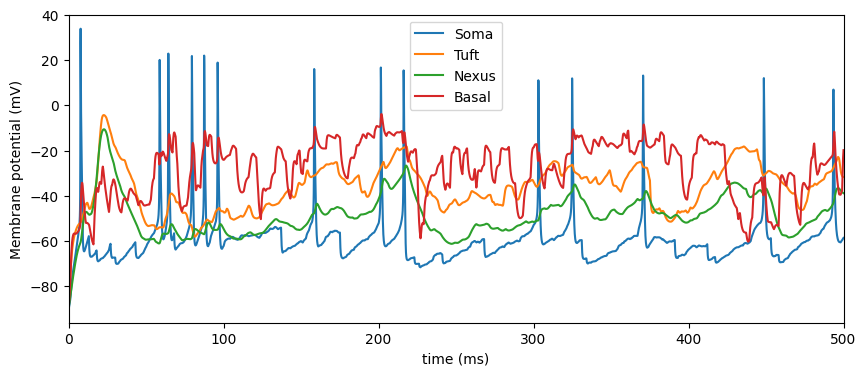

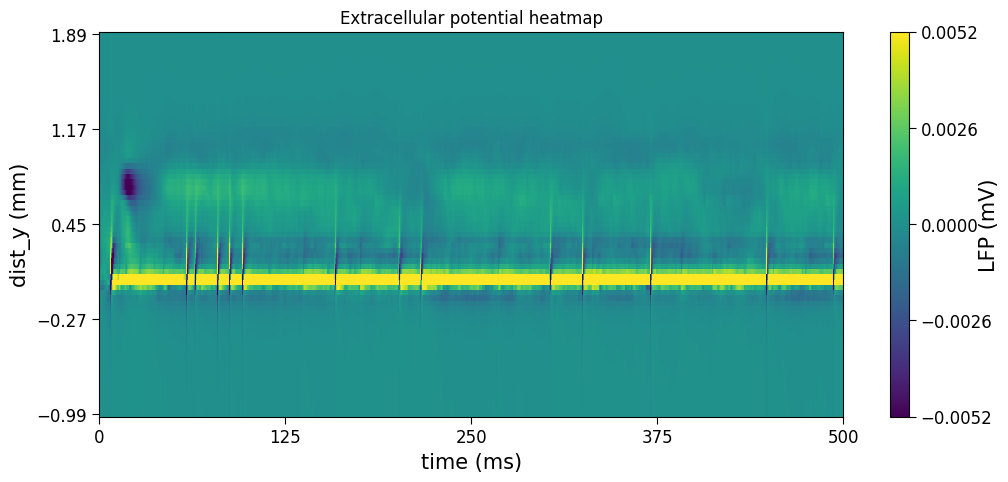

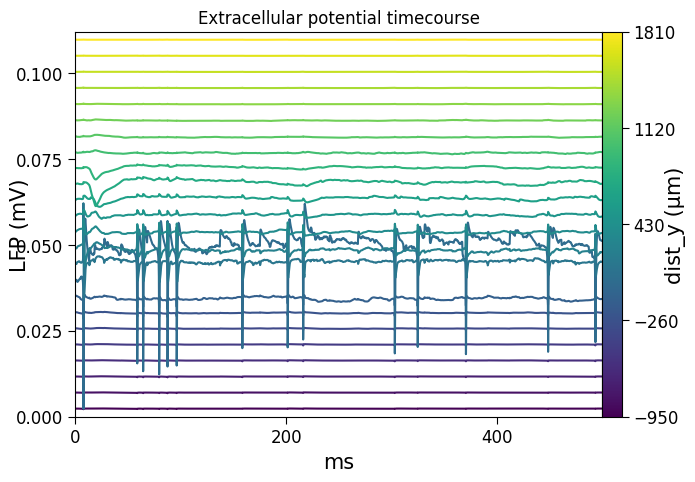

In [27]:
#settings
vlimset='auto'#[-.02,.02]#[-.01,.01]#'auto'#[-.00722,.00722]#'auto'            # heatmap range (mV)
ylimset=[-1000,2500] #[-1200,1200]                                           # y dist range for plotting (microns)

# Run simulation
# if original_syns:
#   set_synapse()
# else: # View synapses
#   for syn in cell.synapse:
#     if syn.gmax_var == '_nc_weight':
#       print(syn.syn, [nc.weight[0] for nc in syn.ncs])
#     else:
#       print('synapse',syn.syn,':',syn.get_segment(),'weight:',syn.syn.initW, 'ncs:',syn.ncs)

h.run()
# Get results
t = t_vec.as_numpy().copy()  # time array (ms)
# soma membrane potential
Vm = V_rec.as_numpy()

soma_seg_index=cell.segments.index(cell.soma[0](0.5))
axon_seg_index=cell.segments.index(cell.axon[-1](0.9))
basal_seg_index=cell.segments.index(basals[0](0.5))
#choose a tuft to plot voltage
if (reduce_cell == True) and ( expand_cable==True): # dendritic reduced model
  tuft_seg_index = tuft_seg_index=cell.segments.index(tufts[0](0.5))# otherwise tufts[0] will be truly tuft section and the segment in the middle of section is fine
  nexus_seg_index = cell.segments.index(cell.apic[0](0.99))
elif (reduce_cell == True) and ( expand_cable==False): # NR model
  tuft_seg_index=cell.segments.index(tufts[0](0.9))# tufts[0] will be the cable that is both trunk and tuft in this case, so we have to specify near end of cable
  nexus_seg_index = cell.segments.index(cell.apic[0](0.289004))
else: # complex cell
  tuft_seg_index=cell.segments.index(tufts[0](0.5))# otherwise tufts[0] will be truly tuft section and the segment in the middle of section is fine
  nexus_seg_index=cell.segments.index(cell.apic[36](0.961538))
print("Plotting",cell.segments[soma_seg_index],"Voltage| y coordinate of this seg:", cell.seg_coords['pc'][soma_seg_index][1])
print("Plotting",cell.segments[tuft_seg_index],"Voltage| y coordinate of this seg:", cell.seg_coords['pc'][tuft_seg_index][1])
print("Plotting",cell.segments[nexus_seg_index],"Voltage| y coordinate of this seg:", cell.seg_coords['pc'][tuft_seg_index][1])

v_soma = Vm[soma_seg_index]
v_tfut = Vm[tuft_seg_index]
v_nexus = Vm[nexus_seg_index]
v_axon = Vm[axon_seg_index]
v_basal = Vm[basal_seg_index]

# lfp array
lfp = ecp.calc_ecp(move_cell=loc_param).T  # unit: mV

# Soma membrane potential
plt.figure(figsize=(10, 4))
plt.plot(t, v_soma, label='Soma')
plt.plot(t, v_tfut, label='Tuft')
plt.plot(t, v_nexus, label='Nexus')
plt.plot(t, v_basal, label='Basal')
# plt.plot(t, v_axon, label='axon')
plt.ylabel('Membrane potential (mV)')
plt.xlabel('time (ms)')
plt.xlim(t[[0, -1]])
plt.legend()
plt.savefig('Vm')

# Extracellular potential along y-axis
y_window = ylimset  # select range of y coordinate for plotting
ylim = loc_param[1] + np.array(y_window)  # set range of y coordinate
max_idx = np.argmax(np.amax(np.abs(lfp), axis=0))  # find the electrode that records maximum magnitude
x_dist = elec_pos[max_idx, 0]  # x coordinate of the maximum magnitude electrode
e_idx = (elec_pos[:, 0]==x_dist) & (elec_pos[:, 1]>=ylim[0]) & (elec_pos[:, 1]<=ylim[1])  # selected electrode indices

fontsize = 15
labelpad = -10
ticksize = 12
tick_length = 5
nbins = 5
plt.figure(figsize=(12, 5))
_ = plot_lfp_heatmap(t=t, elec_d=elec_pos[e_idx, 1], lfp=lfp[:, e_idx],
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim=vlimset, axes=plt.gca()) #vlim='auto';normal range seems to be ~ [-.00722,.00722]
#plt.hlines(0,xmin=min(t),xmax=max(t),linestyles='dashed') # create a horizontal line
plt.title('Extracellular potential heatmap')
plt.savefig('ECP heatmap')
plt.figure(figsize=(8, 5))
_ = plot_lfp_traces(t, lfp[:, e_idx][:,1::3], electrodes=elec_pos[e_idx][1::3],
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.title('Extracellular potential timecourse')
plt.savefig('ECP timecourse')

plt.show()